In [17]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")

# %matplotlib widget

In [18]:
"""
We want to test whether we num fit the basis change for encoding a state for QFT
idea: substitute every Rz in (i)QFT with an Riswap gate
let nuop fit the basis change in order to match the expected histogram
"""

'\nWe want to test whether we num fit the basis change for encoding a state for QFT\nidea: substitute every Rz in (i)QFT with an Riswap gate\nlet nuop fit the basis change in order to match the expected histogram\n'

In [19]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import transpile
from qiskit.converters import circuit_to_dag, dag_to_circuit

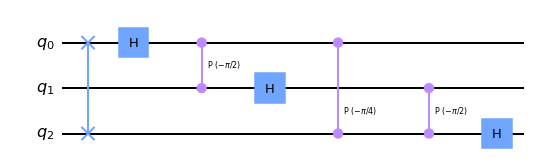

In [ ]:
from qiskit.circuit.library.basis_change import QFT
qsize=3
inverse_qft_lambda = lambda q: QFT(q, inverse=True)
qc = inverse_qft_lambda(qsize)
qc.decompose().draw(output='mpl')

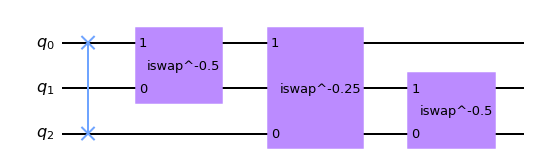

In [ ]:
#replace every R_z with a Riswap?
#replace H gates? -> with generic 1Q gates? 
#can e made a transformation pass if wanted to
from qiskit.circuit.library.standard_gates import iSwapGate
from src.utils.custom_gates import RiSwapGate
dag = circuit_to_dag(qc.decompose())
for node in dag.op_nodes():
    #if we hit a Rz gate then replace it 
    if node.op.name in ["cp"]:
        #get the rotation angle
        angle = node.op.params[0]

        replacement = QuantumCircuit(2)
        #replacement.append(RiSwapGate(angle/np.pi), [0,1])
        replacement.append(iSwapGate().power(angle/np.pi), [0,1])
        
        #replacement.draw(output='mpl')
        dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
    
    #optional, if hadamard gate remove it
    if node.op.name in ["h"]:
        dag.remove_op_node(node)

        # print(angle)
qc_modified = dag_to_circuit(dag)
qc_modified.draw(output='mpl')
#bin algorithms:
#VQE is rotation-based algorithm, doens't matter the basis gate
#versus QFT, not rotation-based, phase-based Hilbert space operations

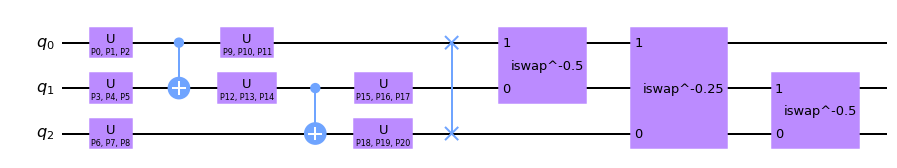

In [ ]:
nqubits = 3
number = 3
prep = QuantumCircuit(qsize)
for qubit in range(qsize):
    prep.h(qubit)
prep.p(number*pi/4,0)
prep.p(number*pi/2,1)
prep.p(number*pi,2)

from src.basis import CircuitTemplate
from qiskit.circuit.library.standard_gates import CXGate
n_qubits = 3
basis = CircuitTemplate(n_qubits = n_qubits, base_gates = [CXGate()], edge_params=[[(0, 1), (1,2)]], preseed=False, use_polytopes=False, no_exterior_1q=0)
basis.build(2)
params = list(basis.circuit.parameters)
prep = basis.circuit

# prep.draw()
qc = prep.compose(qc_modified)
#qc = prep + qc
qc.draw(output='mpl')

In [ ]:
#include free 1Q between 2Q in QFT part of circuit

In [ ]:
# #now simulate the qft to get a histogram
# backend = sim = Aer.get_backend("aer_simulator")
# qc.measure_all()
# transpiled_qc = transpile(qc, backend, optimization_level=0)
# job = backend.run(transpiled_qc)
# job_monitor(job)

In [ ]:
# counts = job.result().get_counts()
# plot_histogram(counts)

NameError: name 'job' is not defined

In [ ]:
#Operator Imports
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian

#Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import EfficientSU2

from qiskit.circuit.library.standard_gates import CXGate
from qiskit.opflow import (StateFn, Zero, One, Plus, Minus, H,
                           DictStateFn, VectorStateFn, CircuitStateFn, OperatorStateFn)

In [ ]:
op = CircuitStateFn(primitive=qc, is_measurement=True)
print(op)

CircuitMeasurement(
     ┌─────────────┐     ┌───────────────┐                           ┌───┐»
q_0: ┤ U(P0,P1,P2) ├──■──┤ U(P9,P10,P11) ├─────────────────────────X─┤ H ├»
     ├─────────────┤┌─┴─┐├───────────────┴┐     ┌────────────────┐ │ └───┘»
q_1: ┤ U(P3,P4,P5) ├┤ X ├┤ U(P12,P13,P14) ├──■──┤ U(P15,P16,P17) ├─┼──────»
     ├─────────────┤└───┘└────────────────┘┌─┴─┐├────────────────┤ │      »
q_2: ┤ U(P6,P7,P8) ├───────────────────────┤ X ├┤ U(P18,P19,P20) ├─X──────»
     └─────────────┘                       └───┘└────────────────┘        »
«     ┌─────────────┐     ┌──────────────┐                    
«q_0: ┤1            ├─────┤1             ├────────────────────
«     │  iswap^-0.5 │┌───┐│              │┌─────────────┐     
«q_1: ┤0            ├┤ H ├┤  iswap^-0.25 ├┤1            ├─────
«     └─────────────┘└───┘│              ││  iswap^-0.5 │┌───┐
«q_2: ────────────────────┤0             ├┤0            ├┤ H ├
«                         └──────────────┘└─────────────┘└───┘
)


In [ ]:
training_loss = []
def optimize(starting_loss=None, starting_guess=None):
    training_loss.append(starting_loss)
    if True or starting_loss is None:
        starting_loss = 1/3 #so alpha = 1/8 which we found was an alright value
    if True or starting_guess is None:
        param_vals = basis.parameter_guess() #random starting guess
    #else:
        #param_vals = optimizer_ret.Xk
    its = 0
    alpha = 1/24*(starting_loss) #arbitary learning rate
    #
    
    c=0
    while True and its < 20:
        if its == 0:
            previous_loss = starting_loss
        its +=1

        alpha *= .9999 #mock simulated annealing 
        if its > 3 and previous_loss < 1/2:
            alpha *= .995
        if its > 3 and previous_loss < 1/4:
            alpha *= .99
        #set param values
        value_dict = {k:v for k,v in zip(params, param_vals)}

        #XXX
        n_qubits = qsize
        measurement_qc = QuantumCircuit(n_qubits)

        # measurement_string = ['xx', 'yx', 'zx', 'xy', 'yy', 'zy', 'xz', 'yz', 'zz']
        # for m_s_el in measurement_string: #what if instead of random we do all of them
        for _ in range(1):
        #     #m_s_el = random.choice(measurement_string)
        #     for q in range(n_qubits):
        #         m_basis = m_s_el[q]
        #         if m_basis == 'x' or m_basis == 'y' or m_basis == 'z':
        #             measurement_qc.h(q)
        #         if m_basis == 'y':
        #             measurement_qc.sdg(q)
        #         if m_basis == 'y' or m_basis == 'z':
        #             measurement_qc.h(q)

        #TODO instead of shuffling the measurement basis, I think we are going to want to shuffle the input state number

            total_qc = measurement_qc.compose(qc)
            op = CircuitStateFn(primitive=total_qc, is_measurement=True)
            #calculate gradient
            grad = Gradient().convert(operator = op, params = params)
            grad_result = grad.assign_parameters(value_dict).eval()

            #alt gradient method
            #state_grad = Gradient(grad_method='param_shift').convert(operator=op, params=params)
            #state_grad_result = state_grad.assign_parameters(value_dict).eval()

            #update param values
            #there are lots of ways I can imagine doing this,
            #for starters, lets just sample the expectation vectorstatefn and only update that one
            # c += 1
            # c %=4

            # bit_convert = ['00', '01', '10','11']
            m = CircuitStateFn(measurement_qc)
            # sample = list(m.eval().sample())[0]
            
            #need to determine if we need to move up or down based on current value
            #right now just says if >.5 go up, but its possible we are already above the value
            #say expectation value is .55 and current anstaz has .75 then should want to go down
            for c in range(2**n_qubits):
                #if np.array(abs(m.to_matrix()) - abs(op.assign_parameters(value_dict).eval().to_matrix()))[0][c] >= 0:

                if [abs(el)>=.5 for el in m.to_matrix()][c]: #bit_convert[c] == sample:
                    param_vals = [el + alpha * gradient_el[c] for el, gradient_el in zip(param_vals, grad_result)]
                else:
                    param_vals = [el - alpha * gradient_el[c] for el, gradient_el in zip(param_vals, grad_result)]

        #param_vals = [el - alpha * gradient_el for el, gradient_el in zip(param_vals, grad_result)]
        
        #for safety
        param_vals = np.real(param_vals)

        #evaluate ground truth
        current_template = basis.eval(Xk=param_vals)
        #gt_cost = cost.unitary_fidelity(current_u= current_template, target_u=target_u)
        #cost is just difference between expected histogram

        # print(gt_cost, alpha)
        # training_loss.append(gt_cost)
        # previous_loss = gt_cost

        #print(op.assign_parameters(value_dict).eval())
    return value_dict
#vd = optimize(starting_loss=previous_loss, starting_guess=optimizer_ret.Xk)
vd = optimize()

import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.xlabel("training iters")
plt.ylabel("unitary fidelity")

NameError: name 'CircuitStateFn' is not defined

In [ ]:
trained_qc = qc.assign_parameters(vd)
trained_qc.draw(output='mpl')